In [17]:
# ========== 1. 环境准备 ==========

!pip install transformers datasets sentencepiece rouge-score pandas matplotlib


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# ========== 2. 导入依赖 ==========

import os
import re
import numpy as np
import pandas as pd
from functools import partial
from datasets import load_dataset, Dataset
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    TrainerCallback
)
from rouge_score import rouge_scorer

In [23]:
# ========== 3. 数据准备 ==========

# 加载数据集
# 读取CSV并转换为Dataset
df = pd.read_csv(r"C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\datasets\data.csv")
dataset = load_dataset('csv', data_files={'train': r"C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\datasets\data.csv"})

# 添加T5所需前缀
def add_prefix(example):
    example["input_text"] = f"translate to ru: {example['comment_zh']}"
    example["target_text"] = example["comment_ru"]
    return example

dataset = dataset.map(add_prefix)
dataset

DatasetDict({
    train: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 1258
    })
})

Null value check:
file_path            0
code                 0
code_comment_type    0
comment_zh           0
comment_ru           0
comment_en           0
dtype: int64


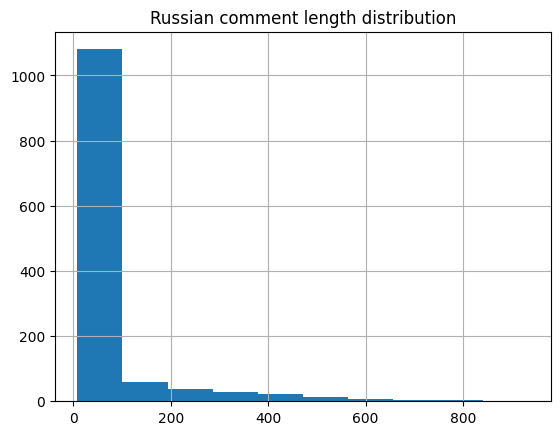

In [24]:
# 检查数据集中是否有空值
print("Null value check:")
print(df.isnull().sum())

# 检查俄语注释长度分布
import matplotlib.pyplot as plt
df['comment_ru'].str.len().hist()
plt.title("Russian comment length distribution")
plt.show()

In [25]:
# 在数据预处理前添加
print("原始数据集样本数:", len(dataset["train"]))
print("列名:", dataset["train"].column_names)
print("首样本中文注释:", dataset["train"][0]["comment_zh"])
print("首样本俄语注释:", dataset["train"][0]["comment_ru"])

原始数据集样本数: 1258
列名: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text']
首样本中文注释: 用于两个样本分位数的自助法t检验
首样本俄语注释: t-тест самообслуживания для двух квартилей выборки


In [26]:
# ========== 4. 数据预处理 ==========

# 加载分词器
tokenizer = T5Tokenizer.from_pretrained("utrobinmv/t5_translate_en_ru_zh_small_1024")

# 增强过滤函数
def filter_invalid_data(example):
    try:
        # 基础有效性检查
        valid = (
            len(example['comment_zh']) >= 3 and
            len(example['comment_ru']) >= 3 and
            not example['comment_zh'].isspace() and
            not example['comment_ru'].isspace()
        )
        return valid
    except:
        return False

# 应用过滤
dataset = dataset.filter(filter_invalid_data, num_proc=os.cpu_count())

# 数据集划分
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Filter (num_proc=8):   0%|          | 0/1258 [00:00<?, ? examples/s]

In [ ]:
# # ========== 4. 数据预处理 ==========

# # 加载分词器
# tokenizer = T5Tokenizer.from_pretrained("utrobinmv/t5_translate_en_ru_zh_small_1024")

# # 增强数据过滤
# def filter_invalid_data(example):
#     try:
#         # Token长度预估
#         zh_tokens = tokenizer.tokenize(example["comment_zh"])
#         ru_tokens = tokenizer.tokenize(example["comment_ru"])
        
#         # 内容有效性检查
#         return (
#             len(zh_tokens) <= 256 and
#             len(ru_tokens) <= 256 and
#             tokenizer.unk_token not in zh_tokens and
#             tokenizer.unk_token not in ru_tokens
#         )
#     except:
#         return False

# # 应用过滤
# dataset = dataset.filter(filter_invalid_data, num_proc=4)

# # 数据集划分
# dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
# ========== 5. 数据预处理函数 ==========

max_input_length = 256
max_target_length = 256

def safe_preprocess(examples, tokenizer):
    """带错误处理的预处理函数"""
    try:
        # 输入处理（中文）
        inputs = tokenizer(
            examples["input_text"],
            max_length=max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
            add_special_tokens=True
        )
        
        # 标签处理（俄语）
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                text_target=examples["target_text"],
                max_length=max_target_length,
                truncation=True,
                padding="max_length",
                return_tensors="pt",
                add_special_tokens=True
            )
        
        # 验证数据有效性
        input_ids = inputs["input_ids"].flatten().tolist()
        label_ids = labels["input_ids"].flatten().tolist()
        
        valid_input = all(0 <= i < tokenizer.vocab_size for i in input_ids)
        valid_label = all(0 <= i < tokenizer.vocab_size for i in label_ids)
        no_unk = tokenizer.unk_token_id not in input_ids + label_ids
        
        if valid_input and valid_label and no_unk:
            return {
                "input_ids": inputs["input_ids"].squeeze(),
                "attention_mask": inputs["attention_mask"].squeeze(),
                "labels": labels["input_ids"].squeeze()
            }
        return None
            
    except Exception as e:
        print(f"预处理异常：{str(e)}")
        return None

# 应用预处理
tokenized_datasets = dataset.map(
    partial(safe_preprocess, tokenizer=tokenizer),
    batched=True,
    batch_size=32,
    num_proc=min(4, os.cpu_count()),
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False
)

# 过滤无效样本
tokenized_datasets = tokenized_datasets.filter(lambda x: x is not None)

Map (num_proc=4):   0%|          | 0/996 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/250 [00:00<?, ? examples/s]

Filter:   0%|          | 0/996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/250 [00:00<?, ? examples/s]

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 996
    })
    test: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 250
    })
})

In [29]:
# ========== 6. 数据验证 ==========
def validate_data():
    assert len(tokenized_datasets["train"]) > 0, "训练集为空，请检查数据过滤条件！"
    
    # 检查数据集特征
    print("\n数据集特征:", tokenized_datasets["train"].features)
    
    # 样本检查
    sample = tokenized_datasets["train"][0]
    print("\n预处理验证：")
    
    # 安全访问字段
    if 'input_ids' in sample:
        print("输入文本:", tokenizer.decode(sample["input_ids"], skip_special_tokens=True))
    else:
        print("错误：缺少input_ids字段")
    
    if 'labels' in sample:
        print("标签文本:", tokenizer.decode(sample["labels"], skip_special_tokens=True))
    else:
        print("错误：缺少labels字段")
    
    # 统计检查
    if 'input_ids' in tokenized_datasets["train"].features:
        input_lens = [len(x["input_ids"]) for x in tokenized_datasets["train"]]
        print(f"\n数据集统计：")
        print(f"训练样本: {len(tokenized_datasets['train'])}")
        print(f"验证样本: {len(tokenized_datasets['test'])}")
        print(f"平均长度: {np.mean(input_lens):.1f} ± {np.std(input_lens):.1f} tokens")
    else:
        print("错误：input_ids字段不存在")

validate_data()


数据集特征: {'file_path': Value(dtype='string', id=None), 'code': Value(dtype='string', id=None), 'code_comment_type': Value(dtype='string', id=None), 'comment_zh': Value(dtype='string', id=None), 'comment_ru': Value(dtype='string', id=None), 'comment_en': Value(dtype='string', id=None), 'input_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None)}

预处理验证：
错误：缺少input_ids字段
错误：缺少labels字段
错误：input_ids字段不存在


In [28]:
# ========== 6. 数据验证 ==========

def validate_data():
    assert len(tokenized_datasets["train"]) > 0, "训练集为空，请检查数据过滤条件！"
    
    # 样本检查
    sample = tokenized_datasets["train"][0]
    print("\n预处理验证：")
    print("输入文本:", tokenizer.decode(sample["input_ids"], skip_special_tokens=True))
    print("标签文本:", tokenizer.decode(sample["labels"], skip_special_tokens=True))
    
    # 统计检查
    input_lens = [len(x["input_ids"]) for x in tokenized_datasets["train"]]
    print(f"\n数据集统计：")
    print(f"训练样本: {len(tokenized_datasets['train'])}")
    print(f"验证样本: {len(tokenized_datasets['test'])}")
    print(f"平均长度: {np.mean(input_lens):.1f} ± {np.std(input_lens):.1f} tokens")

validate_data()


预处理验证：


KeyError: 'input_ids'

In [ ]:
# # ========== 5. 定义预处理函数 ==========

# max_input_length = 256
# max_target_length = 256

# def preprocess_function(examples, tokenizer):
#     try:
#         # 输入处理（中文）
#         model_inputs = tokenizer(
#             examples["input_text"],
#             max_length=max_input_length,
#             truncation="only_first",
#             padding="max_length",
#             add_special_tokens=True,
#             return_tensors="pt"
#         )
        
#         # 标签处理（俄语）
#         with tokenizer.as_target_tokenizer():
#             labels = tokenizer(
#                 text_target=examples["target_text"],
#                 max_length=max_target_length,
#                 truncation="longest_first",
#                 padding="max_length",
#                 add_special_tokens=True,
#                 return_tensors="pt"
#             )
        
#         # 双重有效性验证
#         input_ids = model_inputs["input_ids"].flatten().tolist()
#         label_ids = labels["input_ids"].flatten().tolist()
        
#         invalid_input = any(i >= tokenizer.vocab_size for i in input_ids)
#         invalid_label = any(i >= tokenizer.vocab_size for i in label_ids)
        
#         if invalid_input or invalid_label:
#             print(f"过滤无效样本（输入非法token数：{sum(i >= tokenizer.vocab_size for i in input_ids)}）")
#             return {}
        
#         model_inputs["labels"] = labels["input_ids"]
#         return model_inputs
#     except Exception as e:
#         print(f"预处理异常：{str(e)}")
#         return {}

# # 绑定分词器
# preprocessor = partial(preprocess_function, tokenizer=tokenizer)

# # 应用预处理
# tokenized_datasets = dataset.map(
#     preprocessor,
#     batched=True,
#     batch_size=32,
#     num_proc=4,
#     remove_columns=dataset["train"].column_names,
#     load_from_cache_file=False
# )

# # 过滤空数据（由异常处理产生）
# tokenized_datasets = tokenized_datasets.filter(lambda x: len(x["input_ids"]) > 0)

In [8]:
# ========== 6. 定义评估指标 ==========

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # 处理标签中的-100
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # 过滤空预测
    valid_pairs = [(p, l) for p, l in zip(decoded_preds, decoded_labels) if p.strip() and l.strip()]
    if not valid_pairs:
        return {"rougeL": 0.0}
    
    # 计算ROUGE-L
    scores = [scorer.score(p, l)['rougeL'].fmeasure for p, l in valid_pairs]
    return {"rougeL": round(np.mean(scores), 4)}

In [9]:
# ========== 7. 训练配置 ==========

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-translate-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=False,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    no_cuda=True,
    optim="adamw_torch", # 稳定性优化参数
    gradient_checkpointing=False,
    dataloader_drop_last=True
)

c:\Python310\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Python310\lib\site-packages\transformers\training_args.py:1489: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [10]:
# ========== 8. 安全回调 ==========

class EnhancedSafetyCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        try:
            inputs = kwargs.get("inputs", {})
            
            # 检查所有ID范围
            for key in ["input_ids", "labels"]:
                if key in inputs:
                    ids = inputs[key].cpu().numpy().flatten()
                    invalid_ids = ids[ids >= tokenizer.vocab_size]
                    
                    if len(invalid_ids) > 0:
                        print(f"\n[安全拦截] 检测到非法{key} ID: {invalid_ids[:5]}")
                        print("建议操作：")
                        print("1. 检查预处理过滤条件")
                        print("2. 查看相关样本数据")
                        
                        # 跳过当前batch但不停止训练
                        control.should_training_stop = False
                        control.should_log = False
                        return
        except Exception as e:
            print(f"安全检查异常: {str(e)}")

In [11]:
# ========== 9. 创建Trainer ==========

model = T5ForConditionalGeneration.from_pretrained("utrobinmv/t5_translate_en_ru_zh_small_1024")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[EnhancedSafetyCallback()]
)

In [12]:
# ========== 10. 验证数据质量 ==========

def validate_preprocessing():
    # 检查样本格式
    sample = tokenized_datasets["train"][0]
    print("\n预处理验证：")
    print("输入文本:", tokenizer.decode(sample["input_ids"], skip_special_tokens=True))
    print("标签文本:", tokenizer.decode(sample["labels"], skip_special_tokens=True))
    
    # 统计信息
    input_lens = [len(x["input_ids"]) for x in tokenized_datasets["train"]]
    print(f"\n数据集统计：")
    print(f"总样本数: {len(tokenized_datasets['train'])}")
    print(f"平均输入长度: {np.mean(input_lens):.1f} tokens")
    print(f"最大输入长度: {max(input_lens)} tokens")

validate_preprocessing()

IndexError: Invalid key: 0 is out of bounds for size 0